<a href="https://colab.research.google.com/github/jinbac/tensor/blob/main/PlantNet_Train_Shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Dataset URL
# https://zenodo.org/record/4726653
!wget https://zenodo.org/record/4726653/files/plantnet_300K.zip?download=1

# Get DATSET from here
# https://gitlab.inria.fr/cgarcin/plantnet_dataset

--2021-08-16 01:53:51--  https://zenodo.org/record/4726653/files/plantnet_300K.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31654430714 (29G) [application/octet-stream]
Saving to: ‘plantnet_300K.zip?download=1’

plantnet_300K.zip?d 100%[===================>]  29.48G  24.1MB/s    in 23m 17s 

2021-08-16 02:17:09 (21.6 MB/s) - ‘plantnet_300K.zip?download=1’ saved [31654430714/31654430714]



## Mount Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Tensorflow and other things

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pprint
import json
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

## Check you are running on a TPU

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

Running on TPU  ['10.105.185.130:8470']


## Version Notice
This code assumes you are using tensorflow 2.0 or later and python 3.6 or later

In [ ]:
print("Tensorflow version is " + tf.__version__)
print("Numpy version is " + np.__version__)

Tensorflow version is 2.6.0
Numpy version is 1.19.5


In [ ]:
!pip install git+https://github.com/tensorflow/docs


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ubh4cuwz
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ubh4cuwz
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0f52511c19860e9947261aef83d6b66b6f7a0a3a4_-py3-none-any.whl size=154537 sha256=866b2efe03fe0e664e7ab5ab5a07473d5f156898724e129510d88aa60072bd67
  Stored in directory: /tmp/pip-ephem-wheel-cache-6qfrwxqz/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import tensorflow_docs as tdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:
# Unzips files to google colab
!unzip /content/drive/MyDrive/plantnet/plantnet_300K.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantnet_300K/images_test/1363764/36292b7a83e33de3764ed68fc16543bad5bb07db.jpg  
  inflating: plantnet_300K/images_test/1363764/069f465bf6f0757669985a67789f7fb3a8ab41cc.jpg  
  inflating: plantnet_300K/images_test/1363764/18a7639b314d0f10d985f4872b00d7d5c24982a2.jpg  
  inflating: plantnet_300K/images_test/1363764/db66ae8da58d4b5485324a11b6fa7472cfc07bfb.jpg  
  inflating: plantnet_300K/images_test/1363764/e462607ec30224bb48cb7d286a2436275c1bc01e.jpg  
  inflating: plantnet_300K/images_test/1363764/1d16243c59cced47cd91990b2d1b83f5533914be.jpg  
  inflating: plantnet_300K/images_test/1363764/c947804a38eaa45720b7691fa8560416f621eb12.jpg  
  inflating: plantnet_300K/images_test/1363764/357afa09d847115ef35e14164e4cc5011f9d8f35.jpg  
  inflating: plantnet_300K/images_test/1363764/48db1f52629c8c3bae053b111ea6f42e545283fe.jpg  
  inflating: plantnet_300K/images_test/1363764/cd4a080a296494feccf9505a3fa9b73ab0a633df.jpg  
  inflati

In [ ]:
# Check file unzipped properly and is 31GB
!du -hs plantnet_300K/

31G	plantnet_300K/


In [ ]:
ls plantnet_300K/

images_test/   images_val/                 plantnet300K_species_names.json
images_train/  plantnet300K_metadata.json  README


In [ ]:
 # Check species classes vs folder names
!cat plantnet_300K/plantnet300K_species_names.json

{"1355868": "Lactuca_virosa", "1355920": "Pelargonium_capitatum", "1355932": "Pelargonium_graveolens", "1355936": "Cirsium_arvense", "1355937": "Cirsium_vulgare", "1355955": "Pelargonium_odoratissimum", "1355959": "Pelargonium_peltatum", "1355961": "Pelargonium_quercifolium", "1355978": "Pelargonium_zonale", "1355990": "Mercurialis_annua", "1356003": "Phyllanthus_tenellus", "1356022": "Hypericum_perforatum", "1356037": "Egeria_densa", "1356055": "Ibicella_lutea", "1356075": "Tradescantia_fluminensis", "1356076": "Tradescantia_zebrina", "1356111": "Lamium_amplexicaule", "1356126": "Lavandula_dentata", "1356138": "Striga_asiatica", "1356257": "Melilotus_albus", "1356278": "Trifolium_fragiferum", "1356279": "Asystasia_gangetica", "1356309": "Nymphaea_nouchali", "1356379": "Dryopteris_aemula", "1356380": "Dryopteris_affinis", "1356382": "Dryopteris_filix-mas", "1356420": "Nephrolepis_cordifolia", "1356421": "Nephrolepis_exaltata", "1356428": "Osmunda_regalis", "1356469": "Achyranthes_asper

## Create Datasets for training process

In [ ]:
seed = 123
image_size = (224, 224)
batch_size = 256
train_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    "plantnet_300K/images_train/", labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=image_size, shuffle=True, seed=seed,
    interpolation='bilinear', follow_links=False, smart_resize=True
)
val_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    "plantnet_300K/images_val/", labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=image_size,
     shuffle=True, seed=seed,
    interpolation='bilinear', follow_links=False, smart_resize=True
)

test_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    "plantnet_300K/images_test/", labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=image_size,
     shuffle=True, seed=seed,
    interpolation='bilinear', follow_links=False, smart_resize=True
)

Found 243916 files belonging to 1081 classes.
Found 31118 files belonging to 1081 classes.
Found 31112 files belonging to 1081 classes.


In [ ]:
# import numpy as np
train_dataset_raw.shuffle(buffer_size=1024)
# it = iter(train_dataset_raw)
# next(it)

NameError: ignored

## Preprocess Datasets

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
PREPROCESS = True
BATCH_SIZE = 256

if PREPROCESS:
  # Resize all Images
  @tf.function
  def process_dataset(image, label):
    # image = tf.image.resize(image, (224, 224))
    # image = preprocess_input(image)
    image = image/127.0 - 1 #normalize around -1 to +1
    return(image, label)

  train_dataset = train_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)
  val_dataset = val_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)
  test_dataset = test_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)

else:
  train_dataset = train_dataset_raw
  val_dataset = val_dataset_raw
  test_dataset = test_dataset_raw



## Create Model Base from MobileNetV2 without top layers


In [ ]:
# Mobilenet was originally trained with -1 to +1 values, Normalizer sets images within this range so pretrained weights work properly
# normalizer = tf.keras.layers.experimental.preprocessing.Normalization(mean=0, variance=1)
# inputs = tf.keras.Input(shape=(224,224,3))
# input_layer = normalizer(inputs)
# normalizer.adapt(train_dataset_raw.batch(128))


base_model = tf.keras.applications.MobileNetV2(
    input_shape = (224,224,3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    pooling=None,
    classifier_activation="softmax",
)

# Combine input layer with base model
# full_model = Model(inputs=[inputs], outputs=[base_model.output])

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
it = iter(test_dataset_raw)

In [ ]:
batch_images = next(it)[0]

In [ ]:
single_image = batch_images[0]

In [ ]:
single_image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 69.998405  ,  47.83769   ,  11.319835  ],
        [ 68.7669    ,  50.367985  ,   9.963329  ],
        [ 67.144135  ,  48.947704  ,  13.443559  ],
        ...,
        [ 33.674442  ,  24.67444   ,   7.674441  ],
        [ 29.553467  ,  20.553467  ,   5.553467  ],
        [ 23.186543  ,  13.186542  ,   1.1865419 ]],

       [[ 69.49394   ,  46.493942  ,  12.493941  ],
        [ 66.50064   ,  47.018494  ,  13.821747  ],
        [ 39.636795  ,  22.125956  ,   0.38743618],
        ...,
        [ 28.833874  ,  20.541126  ,   6.482143  ],
        [ 29.981506  ,  21.499363  ,   7.5350776 ],
        [ 27.910723  ,  18.946438  ,   6.42858   ]],

       [[ 66.07302   ,  46.402744  ,  10.916454  ],
        [ 62.898914  ,  45.225765  ,  17.588327  ],
        [ 30.800064  ,  13.427934  ,   1.687183  ],
        ...,
        [ 25.23501   ,  19.23501   ,   5.2350097 ],
        [ 25.767927  ,  19.767927  ,   5.7679267 ],
        [ 29.28157

In [ ]:
preprocess_input(single_image)

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[-0.45099288, -0.6248025 , -0.911217  ],
        [-0.46065176, -0.604957  , -0.9218562 ],
        [-0.4733793 , -0.61609644, -0.89456034],
        ...,
        [-0.7358867 , -0.806475  , -0.9398083 ],
        [-0.7682081 , -0.8387963 , -0.9564434 ],
        [-0.8181448 , -0.89657617, -0.9906938 ]],

       [[-0.4549495 , -0.63534164, -0.9020083 ],
        [-0.47842634, -0.6312275 , -0.8915942 ],
        [-0.68912315, -0.8264631 , -0.9969613 ],
        ...,
        [-0.773852  , -0.8388931 , -0.9491597 ],
        [-0.7648509 , -0.83137757, -0.94090134],
        [-0.7810924 , -0.8514005 , -0.9495798 ]],

       [[-0.48178023, -0.6360569 , -0.9143807 ],
        [-0.5066752 , -0.6452881 , -0.8620523 ],
        [-0.75843084, -0.8946829 , -0.9867672 ],
        ...,
        [-0.80207837, -0.8491372 , -0.9589411 ],
        [-0.7978986 , -0.8449575 , -0.9547614 ],
        [-0.77034056, -0.8173994 , -0.92720336]],

       ...,

     

In [ ]:
it = iter(test_dataset)
single_image_norm = next(it)[0][0]
single_image_norm
# x = (single_image_norm - preprocess_input(single_image))
# print(x)

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 0.86916983,  0.70381546,  0.45972097],
        [ 0.8920611 ,  0.72670674,  0.48261225],
        [ 0.90027916,  0.71917677,  0.47508228],
        ...,
        [-0.35068822, -0.46092445, -0.6656488 ],
        [-0.4258592 , -0.49883658, -0.68748343],
        [-0.27646118, -0.2953955 , -0.4754358 ]],

       [[ 0.7070695 ,  0.5498704 ,  0.30169833],
        [ 0.86939585,  0.7040415 ,  0.459947  ],
        [ 0.81366503,  0.63256276,  0.38846827],
        ...,
        [-0.25093758, -0.3388723 , -0.5387182 ],
        [-0.38160467, -0.419289  , -0.6202167 ],
        [-0.05923784, -0.04170722, -0.23476124]],

       [[ 0.76827896,  0.6186726 ,  0.38245213],
        [ 0.81548035,  0.6577188 ,  0.42557597],
        [ 0.66813385,  0.5027795 ,  0.27443302],
        ...,
        [ 0.04112053, -0.00518435, -0.2111516 ],
        [-0.37386906, -0.36500967, -0.5816854 ],
        [ 0.0017097 ,  0.07819998, -0.15270996]],

       ...,

     

## Add Top layer to base model

In [ ]:
# normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
# normalizer.adapt(train_dataset_raw.batch(128))

# inputs = tf.keras.Input(shape=(224,224,3))
# x = normalizer(inputs)
# x = tf.keras.backend.function([x, tf.keras.backend.learning_phase()], base_model.input) 
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation="relu")(x)
predictions = Dense(1081, activation="softmax")(x)

## Finish creating complete model



In [ ]:
# model = Model(inputs = inputs, outputs = predictions)
model = Model(inputs = base_model.input, outputs = predictions)

## Freeze the model middle layers

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False
base_model.trainable = True

In [ ]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy' , metrics= ["accuracy"])

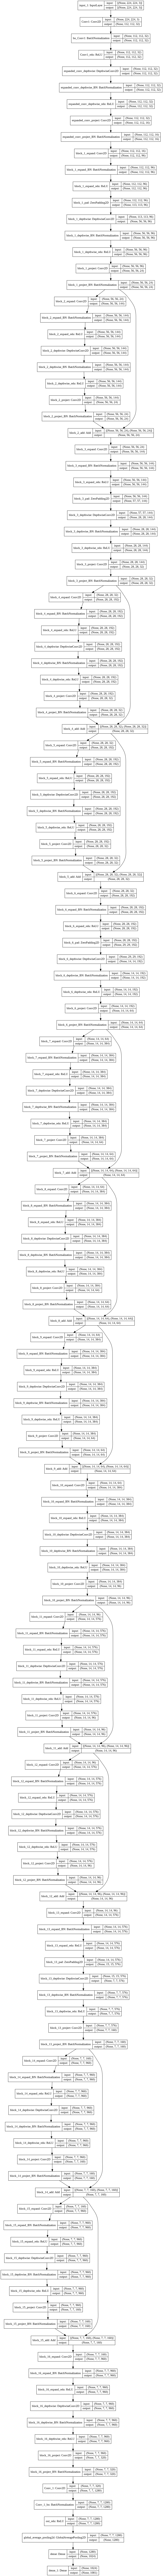

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
# Callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime 

current_time = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
gdrive_dir = "/content/drive/MyDrive/saved_models/"
# filepath = "{}plantNet_20210809{}.h5".format(gdrive_dir, "{}".format("_Trainable" if base_model.trainable else ""))
filepath = ""

# Try loading model at filepath to continue training
# If no file exists then it creates a new one
try:
  model = keras.models.load_model(filepath)
  print("Continuing training from checkpoint")
except:
  print("No keras model found at {}, will start training from scratch.".format(filepath))
  filepath = "{0}plantNet_{1}{2}.h5".format(gdrive_dir, datetime.now().strftime('%Y%m%d'), "_Trainable" if base_model.trainable else "")
  print("New model filename is {}".format(filepath))


# Save model only when validation accuracy increases
# checkpoint = ModelCheckpoint(filepath, monitor="val_acc", verbose=1, save_best_only=True, mode="max")
checkpoint = ModelCheckpoint(filepath, save_best_only=False, save_weights_only=False)


# Stop training model if validation loss does not improve for 3 epochs
earlyStopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

callbacks_list = [checkpoint, earlyStopping]

No keras model found at , will start training from scratch.
New model filename is /content/drive/MyDrive/saved_models/plantNet_20210820_Trainable.h5


## Train Model

In [ ]:
epochs = 1
steps_per_epoch = None
# val_dataset = None
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=callbacks_list, steps_per_epoch=steps_per_epoch)



 76/953 [=>............................] - ETA: 1:42:26 - loss: 3.6522 - accuracy: 0.3374

KeyboardInterrupt: ignored

'Trainable'

In [ ]:
ls

drive/  model.png  plantnet_300K/  sample_data/
